In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import random as rn
import os
import matplotlib.pyplot as plt
import scipy.io
import random
from scipy import stats
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model,layers,Sequential,regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import CSVLogger
import sklearn
from sklearn.metrics import multilabel_confusion_matrix
import sys
import cv2
from numba import cuda
import warnings
warnings.filterwarnings('ignore')

C:\Users\Marko\Anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Marko\Anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Marko\Anaconda3\envs\myenv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Marko\Anaconda3\envs\myenv\lib\site-packages\tensorflow\python\f

In [69]:
def builder(num_classes, input_size=(256, 256), model='SegNet', base_model=None):
    """
    Function which builds a network from the provided base_model(initial weights) and the provided specialized model(default 'SegNet')
    """
    models = {'FCN-8s': FCN,
              'FCN-16s': FCN,
              'FCN-32s': FCN,
              'UNet': UNet,
              'SegNet': SegNet,
              'Bayesian-SegNet': SegNet,
              'PAN': PAN,
              'PSPNet': PSPNet,
              'RefineNet': RefineNet,
              'DenseASPP': DenseASPP,
              'DeepLabV3': DeepLabV3,
              'DeepLabV3Plus': DeepLabV3Plus,
              'BiSegNet': BiSegNet}

    #assert model in models ; need to get models first

    # Call to suitable model constructor
    net = models[model](num_classes, model, base_model)

    inputs = layers.Input(shape=input_size+(3,))

    # Call to _model function from suitable model class
    return net(inputs), net.get_base_model()


def train_model(model, dataset, num_classes, loss, num_epochs=10, batch_size=32, learning_rate=3e-4,
                initial_weights=None, steps_per_epoch=None, num_valid_images=20, valid_batch_size=1,
                random_seed=None, target_size=(256,256), optimizer=None):
    """
    Function which trains and saves the weights for the provided model already built by the builder function
    Parameters:
    model: the model built by the builder function which you want to use, tf.Model
    dataset: path to the dataset, str
    num_classes: number of classes in the dataset, int
    loss: loss function to use ('ce','focal_loss','miou_loss','self_balanced_focal_loss'), str
    num_epochs: how many epochs to train for, int
    batch_size: the batch size, int
    learning_rate: the learning rate, float
    initial_weights: specify this if you want to retrain the model from an already defined starting point; specifies the path to the weights, str
    steps_per_epoch: computed from the batch size and number of images, can be overriden here, int
    num_valid_images: number of validation images, int
    valid_batch_size: batch size for the validation images, int
    random_seed: random seed for the compilation of the model, int
    """

    # get image and label file names for training and validation
    train_image_names, train_label_names, valid_image_names, valid_label_names, _, _ = get_dataset_info(dataset)

    # summary
    model.summary()

    # load weights
    if initial_weights is not None:
        print('Loading the weights...')
        model.load_weights(initial_weights)

    # choose loss type
    # Utils functions
    losses = {'ce': categorical_crossentropy_with_logits,
              'focal_loss': focal_loss(),
              'miou_loss': miou_loss(num_classes=num_classes),
              'self_balanced_focal_loss': self_balanced_focal_loss()}

    assert loss in list(losses.keys())

    if loss is not None:
        loss = losses[loss]
    else:
        loss = losses['ce']

    # choose optimizer
    total_iterations = len(train_image_names) * num_epochs // batch_size
    # Utils functions
    wd_dict = get_weight_decays(model)
    ordered_values = []
    weight_decays = fill_dict_in_order(wd_dict, ordered_values)

    optimizers = {'adam': tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  'nadam': tf.keras.optimizers.Nadam(learning_rate=learning_rate),
                  'sgd': tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.99),
                  'adamw': AdamW(learning_rate=learning_rate, batch_size=batch_size,
                                total_iterations=total_iterations),
                  'nadamw': NadamW(learning_rate=learning_rate, batch_size=batch_size,
                                  total_iterations=total_iterations),
                  'sgdw': SGDW(learning_rate=learning_rate, momentum=0.99, batch_size=batch_size,
                              total_iterations=total_iterations)}
    if optimizer is not None:
        optimizer = optimizers[optimizer]
    else:
        optimizer = optimizers['adam']

    # training and validation steps
    steps_per_epoch = len(train_image_names) // batch_size if not steps_per_epoch else steps_per_epoch
    # Ne znam so prai
    validation_steps = num_valid_images // valid_batch_size
    

    # compile the model
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=[MeanIoU(num_classes)])
    
    # data generator
    # data augmentation setting
    train_gen = ImageDataGenerator()
    valid_gen = ImageDataGenerator()

    train_generator = train_gen.flow(images_list=train_image_names,
                                    labels_list=train_label_names,
                                    num_classes=num_classes,
                                    batch_size=batch_size,
                                    target_size=target_size,
                                    seed=random_seed)

    valid_generator = valid_gen.flow(images_list=valid_image_names,
                                    labels_list=valid_label_names,
                                    num_classes=num_classes,
                                    batch_size=valid_batch_size,
                                    target_size=target_size)
    
    # begin training
    print("\n***** Begin training *****")
    print("Dataset -->", dataset)
    print("Num Images -->", len(train_image_names))
    print("Model -->", model)
    print("Base Model -->", base_model)
    print("Crop Height -->", target_size[0])
    print("Crop Width -->", target_size[1])
    print("Num Epochs -->", num_epochs)
    print("Batch Size -->", batch_size)
    print("Num Classes -->", num_classes)
    print("")

    # training...
    model.fit(train_generator,
                        steps_per_epoch=steps_per_epoch,
                        epochs=num_epochs,
                        validation_data=valid_generator,
                        validation_steps=validation_steps,
                        validation_freq=1,
                        max_queue_size=10,
                        workers=os.cpu_count(),
                        use_multiprocessing=False)

    # save weights to drive here
    # model.save(filepath=os.path.join(
    #     paths['weights_path'], '{model}_based_on_{base_model}.h5'.format(model=args.model, base_model=base_model)))
    return model


def evaluate_predictions(dataset, predictions, target_size=(256,256)):
    """
    Functions which evaluates the predictions only regarding the target dataset specified in the evaluated_classes.txt file in the dataset folder
    Parameters:
    dataset: path to the dataset, str
    predictions: path to the predictions file, str
    """
    # get image and label file names for training and validation
    _, _, _, _, _, test_label_names = get_dataset_info(dataset)

    # get color info
    csv_file = os.path.join(dataset, 'class_dict.csv')

    # Utils function
    class_names, _ = get_colored_info(csv_file)

    # get the prediction file name list, need to navigate from drive here
    if not os.path.exists(predictions):
        raise ValueError('the path of predictions does not exit.')

    prediction_names = []
    for file in sorted(os.listdir(predictions)):
        prediction_names.append(os.path.join(predictions, file))

    # evaluated classes
    evaluated_classes = get_evaluated_classes(os.path.join(dataset, 'evaluated_classes.txt'))

    num_classes = len(class_names)
    class_iou = dict()
    for name in evaluated_classes:
        class_iou[name] = list()

    class_idx = dict(zip(class_names, range(num_classes)))

    # begin evaluate
    assert len(test_label_names) == len(prediction_names)

    for i, (name1, name2) in enumerate(zip(test_label_names, prediction_names)):
        sys.stdout.write('\rRunning test image %d / %d' % (i + 1, len(test_label_names)))
        sys.stdout.flush()

        label = np.array(cv2.resize(load_image(name1),
                                    dsize=(target_size[0], target_size[1]), interpolation=cv2.INTER_NEAREST))
        pred = np.array(cv2.resize(load_image(name2),
                                  dsize=(target_size[0], target_size[1]), interpolation=cv2.INTER_NEAREST))

        confusion_matrix = multilabel_confusion_matrix(label.flatten(), pred.flatten(), labels=list(class_idx.values()))
        for eval_cls in evaluated_classes:
            eval_idx = class_idx[eval_cls]
            (tn, fp), (fn, tp) = confusion_matrix[eval_idx]

            if tp + fn > 0:
                class_iou[eval_cls].append(tp / (tp + fp + fn))

    print('\n****************************************')
    print('* The IoU of each class is as follows: *')
    print('****************************************')
    for eval_cls in evaluated_classes:
        class_iou[eval_cls] = np.mean(class_iou[eval_cls])
        print('{cls:}: {iou:.4f}'.format(cls=eval_cls, iou=class_iou[eval_cls]))

    print('\n**********************************************')
    print('* The Mean IoU of all classes is as follows: *')
    print('**********************************************')
    print('Mean IoU: {mean_iou:.4f}'.format(mean_iou=np.mean(list(class_iou.values()))))


def test_model(model, dataset, num_classes, batch_size=5, target_size=(256,256), base_model=None):
    """
    Function which tests the provided model on the provided dataset
    Parameters:
    model: the model built by the builder function which you want to use, tf.Model
    dataset: path to the dataset, str
    num_classes: number of classes in the dataset, int
    batch_size: the batch size, int 
    base_model: the base model, string or None
    """
    # get image and label file names for training and validation
    _, _, _, _, test_image_names, test_label_names = get_dataset_info(dataset)

    # data generator
    test_gen = ImageDataGenerator()

    test_generator = test_gen.flow(images_list=test_image_names,
                                  labels_list=test_label_names,
                                  num_classes=num_classes,
                                  batch_size=batch_size,
                                  target_size=target_size)
    if base_model is None:
        base_model='VGG16'
    # begin testing
    print("\n***** Begin testing *****")
    print("Dataset -->", dataset)
    print("Model -->", model)
    print("Base Model -->", base_model)
    print("Crop Height -->", target_size[0])
    print("Crop Width -->", target_size[1])
    print("Testing Batch Size -->", batch_size)
    print("Num Classes -->", num_classes)
    print("")

    # some other training parameters
    steps = len(test_image_names) // batch_size

    # testing
    scores = model.evaluate(test_generator, steps=steps, workers=os.cpu_count(), use_multiprocessing=False)

    print('loss={loss:0.4f}, MeanIoU={mean_iou:0.4f}'.format(loss=scores[0], mean_iou=scores[1]))


def predict_image(model, image_path, dataset, num_classes, color_encoded=True, target_size=(256,256), base_model=None):
    """
    Function which tests the provided model on only one image
    Parameters:
    model: the model built by the builder function which you want to use, tf.Model
    image_path: the path of the image to be segmented, str
    dataset: path to the dataset, str
    num_classes: number of classes in the dataset, int
    color_encoded: whether to color encode the resulting segmented image according to the class_dict file
    base_model: the base model, string or None
    """

    # check the image path in drive
    if not os.path.exists(image_path):
        raise ValueError('The path \'{}\' does not exist the image file.'.format(image_path))

    if base_model is None:
        base_model='VGG16'
    # begin testing
    print("\n***** Begin testing *****")
    print("Model -->", model)
    print("Base Model -->", base_model)
    print("Num Classes -->", num_classes)
    print("")

    # load_images
    image_names=list()
    if os.path.isfile(image_path):
        image_names.append(image_path)
    else:
        for f in os.listdir(image_path):
            image_names.append(os.path.join(image_path, f))
        image_names.sort()

   
    csv_color_file = os.path.join(dataset, 'class_dict.csv')
    _, color_values = get_colored_info(csv_color_file)

    for i, name in enumerate(image_names):
        sys.stdout.write('\rRunning test image %d / %d'%(i+1, len(image_names)))
        sys.stdout.flush()

        image = cv2.resize(load_image(name),
                          dsize=target_size)
        image = imagenet_utils.preprocess_input(image.astype(np.float32), data_format='channels_last', mode='torch')

        # image processing
        if np.ndim(image) == 3:
            image = np.expand_dims(image, axis=0)
        assert np.ndim(image) == 4

        # get the prediction
        prediction = model.predict(image)

        if np.ndim(prediction) == 4:
            prediction = np.squeeze(prediction, axis=0)

        # decode one-hot
        prediction = decode_one_hot(prediction)

        # color encode
        if color_encoded:
            prediction = color_encode(prediction, color_values)

        # get PIL file
        prediction = Image.fromarray(np.uint8(prediction))

        # save the prediction to drive
        # _, file_name = os.path.split(name)
        # prediction.save(os.path.join(paths['prediction_path'], file_name))
        return prediction
    
    
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst


def to_image(matrix_name):
    img = Image.fromarray(matrix_name)
    return img


def create_model_results_for_dataset(model,dataset,result_folder_name):
    cm = plt.get_cmap('inferno', lut=32)
    folders_images = ["train/images","test/images","valid/images"]
    folders_labels = ["train/labels","test/labels","valid/labels"]
    for folder_image,folder_label in zip(folders_images,folders_labels):
        path_image = os.path.join(dataset,folder_image)
        image_names = os.listdir(path_image)
        path_label = os.path.join(dataset,folder_label)
        label_names = os.listdir(path_label)
        for image_name,label_name in zip(image_names,label_names):
            image_full_name = os.path.join(path_image,image_name)
            original_image = Image.open(image_full_name)
            label_full_name = os.path.join(path_label,label_name)
            label_img = cv2.imread(label_full_name,0)
            colored_label = cm(label_img)
            new_label_image = Image.fromarray((colored_label[:, :]* 255).astype(np.uint8))
            pred_img = predict_image(model, image_full_name, dataset, num_classes=14)
            new_label_image.thumbnail((256,256),Image.ANTIALIAS)
            combined_img  = get_concat_h(new_label_image,pred_img)
            combined_img.save(os.path.join(result_folder_name,image_name))

In [3]:
import sys
sys.path.append('ImageSegmentationDeepLearning/Amazing-Semantic-Segmentation')
from models.network import Network
from models.fcn import FCN
from models.pspnet import PSPNet
from models.segnet import SegNet
from models.unet import UNet
from models.pan import PAN
from models.deeplab_v3 import DeepLabV3
from models.deeplab_v3_plus import DeepLabV3Plus
from models.refinenet import RefineNet
from models.denseaspp import DenseASPP
from models.bisegnet import BiSegNet
from utils.utils import *
from utils.callbacks import *
from utils.data_generator import *
from utils.layers import *
from utils.learning_rate import *
from utils.losses import *
from utils.optimizers import *
from utils.metrics import *
from utils.helpers import *
layers = tf.keras.layers

In [5]:
os.chdir('ImageSegmentationDeepLearning/Amazing-Semantic-Segmentation')

## DeepLabV3

#### On CamVid dataset

In [31]:
model, base_model = builder(num_classes=32, model='DeepLabV3')

In [32]:
model = train_model(model, dataset='CamVid', loss='ce', num_classes=32, num_epochs=16, batch_size=16)

Model: "DeepLabV3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________


***** Begin training *****
Dataset --> CamVid
Num Images --> 421
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> ResNet50
Crop Height --> 256
Crop Width --> 256
Num Epochs --> 16
Batch Size --> 16
Num Classes --> 32

Epoch 1/16
26/26 [==============================] - 1872s 72s/step - loss: 102581.7993 - mean_io_u_2: 0.0732 - val_loss: 29435874.0000 - val_mean_io_u_2: 0.0268
Epoch 2/16
26/26 [==============================] - 1654s 64s/step - loss: 65636.0411 - mean_io_u_2: 0.1187 - val_loss: 7348547.1500 - val_mean_io_u_2: 0.0210
Epoch 3/16
26/26 [==============================] - 1656s 64s/step - loss: 55976.3145 - mean_io_u_2: 0.1483 - val_loss: 1113419.2344 - val_mean_io_u_2: 0.0256
Epoch 4/16
26/26 [==============================] - 1655s 64s/step - loss: 49029.8611 - mean_io_u_2: 0.1736 - val_loss: 353115.3609 - val_mean_io_u_2: 0.0531
Epoch 5/16
26/26 [==============================] - 1655s 64s/step - loss: 44492.4186 - mea

In [33]:
model.save('DeepLabV3_VGG16base_CamVid_16_epochs.h5')

#### Testing model

In [34]:
test_model(model, dataset='CamVid', num_classes=32)


***** Begin testing *****
Dataset --> CamVid
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Crop Height --> 256
Crop Width --> 256
Testing Batch Size --> 5
Num Classes --> 32

33/33 [==============================] - 23s 701ms/step - loss: 42337.1849 - mean_io_u_2: 0.2341
loss=42337.1849, MeanIoU=0.2341



***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 32

Running test image 1 / 1

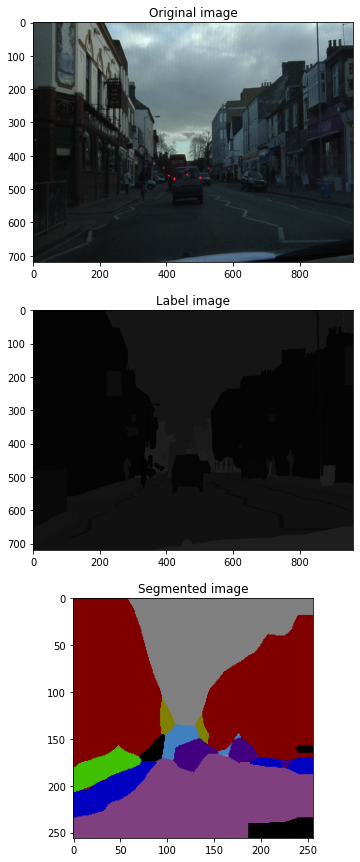

In [35]:
img = cv2.cvtColor(cv2.imread('CamVid/test/images/0001TP_007860.png'), cv2.COLOR_BGR2RGB)
label = cv2.imread('CamVid/test/labels/0001TP_007860_L.png')
pred = predict_image(model, 'CamVid/test/images/0001TP_007860.png', 'CamVid', num_classes=32)

fig = plt.figure(figsize=(15,15))
fig.subplots(3,1)

plt.subplot(311)
plt.title('Original image')
plt.imshow(img)

plt.subplot(312)
plt.title('Label image')
plt.imshow(label, cmap='gray')

plt.subplot(313)
plt.title('Segmented image')
plt.imshow(pred)

plt.show()

### Generating results for CamVid dataset

In [70]:
create_model_results_for_dataset(model,'CamVid','DeepLab_CamVid_16_epochs_results')


***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FD

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Mod

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Mod

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Mod

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Mod

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Mod

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Mod

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Mod

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Mod

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Mod

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Mod

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Mod

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Mod

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Mod

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Mod

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FDEA5CBE0>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Mod

#### On MSRC dataset

In [13]:
model, base_model = builder(num_classes=14, model='DeepLabV3')

In [14]:
model = train_model(model, dataset='MSRC', loss='ce', num_classes=14, num_epochs=20, batch_size=16)

Model: "DeepLabV3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________


***** Begin training *****
Dataset --> MSRC
Num Images --> 144
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> ResNet50
Crop Height --> 256
Crop Width --> 256
Num Epochs --> 20
Batch Size --> 16
Num Classes --> 14

Epoch 1/20
9/9 [==============================] - 678s 75s/step - loss: 223779.9792 - mean_io_u_1: 0.0760 - val_loss: 12567563443.2000 - val_mean_io_u_1: 0.0198
Epoch 2/20
9/9 [==============================] - 660s 73s/step - loss: 142157.7387 - mean_io_u_1: 0.1012 - val_loss: 3317144816.0000 - val_mean_io_u_1: 0.0234
Epoch 3/20
9/9 [==============================] - 628s 70s/step - loss: 126068.7109 - mean_io_u_1: 0.1331 - val_loss: 626486287.6000 - val_mean_io_u_1: 0.0231
Epoch 4/20
9/9 [==============================] - 610s 68s/step - loss: 104737.4722 - mean_io_u_1: 0.2052 - val_loss: 102137045.9000 - val_mean_io_u_1: 0.0318
Epoch 5/20
9/9 [==============================] - 609s 68s/step - loss: 94782.3186 - mean_i

In [15]:
model.save('DeepLabV3_VGG16base_MSRC_20epochs.h5')

In [16]:
test_model(model, dataset='MSRC', num_classes=14)


***** Begin testing *****
Dataset --> MSRC
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Crop Height --> 256
Crop Width --> 256
Testing Batch Size --> 5
Num Classes --> 14

11/11 [==============================] - 8s 701ms/step - loss: 109993.7493 - mean_io_u_1: 0.3195
loss=109993.7493, MeanIoU=0.3195



***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1

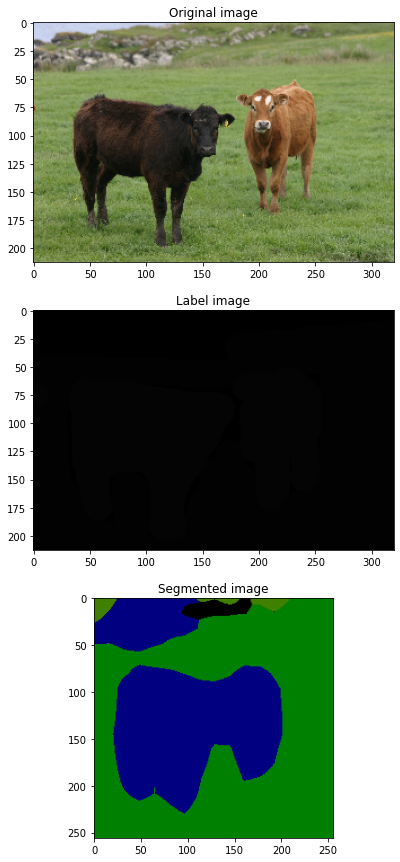

In [22]:
img = cv2.cvtColor(cv2.imread('MSRC/test/images/1_19_s.png'), cv2.COLOR_BGR2RGB)
label = cv2.imread('MSRC/test/labels/1_19_s_L.png')
pred = predict_image(model, 'MSRC/test/images/1_19_s.png', 'MSRC', num_classes=14)

fig = plt.figure(figsize=(15,15))
fig.subplots(3,1)

plt.subplot(311)
plt.title('Original image')
plt.imshow(img)

plt.subplot(312)
plt.title('Label image')
plt.imshow(label, cmap='gray')

plt.subplot(313)
plt.title('Segmented image')
plt.imshow(pred)

plt.show()

### Generating results for MSRC dataset

In [29]:
create_model_results_for_dataset(model,'MSRC','DeepLab_MSRC_20_epochs_results')


***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Mod

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Mod

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Mod

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Mod

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FC6B5F0B8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1
***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Mod

### SegNet

#### On CamVid dataset

In [16]:
model2, base_model2 = builder(num_classes=32, model='SegNet')

In [17]:
model2 = train_model(model2, dataset='CamVid', loss='ce', num_classes=32, num_epochs=20, batch_size=16)

Model: "SegNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 64, 64, 256)       29516


***** Begin training *****
Dataset --> CamVid
Num Images --> 421
Model --> <tensorflow.python.keras.engine.training.Model object at 0x000002042CC29AC8>
Base Model --> ResNet50
Crop Height --> 256
Crop Width --> 256
Num Epochs --> 20
Batch Size --> 16
Num Classes --> 32

Epoch 1/20
26/26 [==============================] - 587s 23s/step - loss: 178930.7424 - mean_io_u_4: 0.0664 - val_loss: 101979412.8000 - val_mean_io_u_4: 9.5438e-05
Epoch 2/20
26/26 [==============================] - 676s 26s/step - loss: 151929.2321 - mean_io_u_4: 0.0975 - val_loss: 12709004.1000 - val_mean_io_u_4: 7.2508e-04
Epoch 3/20
26/26 [==============================] - 695s 27s/step - loss: 141334.3875 - mean_io_u_4: 0.1087 - val_loss: 752657.1578 - val_mean_io_u_4: 0.0104
Epoch 4/20
26/26 [==============================] - 707s 27s/step - loss: 132074.8682 - mean_io_u_4: 0.1245 - val_loss: 252435.1203 - val_mean_io_u_4: 0.0451
Epoch 5/20
26/26 [==============================] - 724s 28s/step - loss: 126529.40

In [18]:
model2.save('SegNet_VGG16base_CamVid_20epochs.h5')

In [19]:
test_model(model2, dataset='CamVid', num_classes=32)


***** Begin testing *****
Dataset --> CamVid
Model --> <tensorflow.python.keras.engine.training.Model object at 0x000002042CC29AC8>
Base Model --> VGG16
Crop Height --> 256
Crop Width --> 256
Testing Batch Size --> 5
Num Classes --> 32

33/33 [==============================] - 76s 2s/step - loss: 103442.1593 - mean_io_u_4: 0.1964
loss=103442.1593, MeanIoU=0.1964



***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x000002042CC29AC8>
Base Model --> VGG16
Num Classes --> 32

Running test image 1 / 1

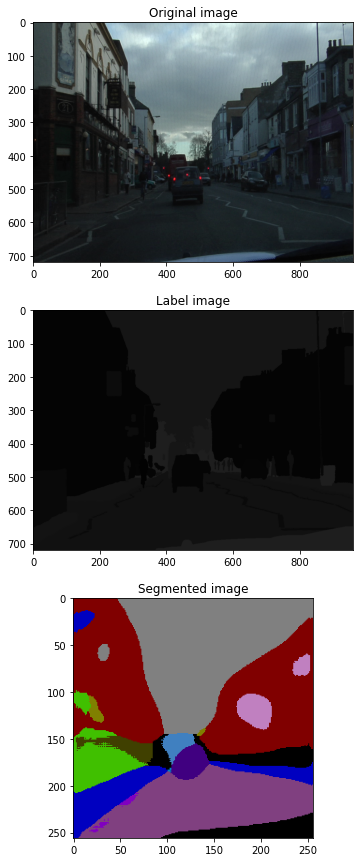

In [21]:
img = cv2.cvtColor(cv2.imread('CamVid/test/images/0001TP_007860.png'), cv2.COLOR_BGR2RGB)
label = cv2.imread('CamVid/test/labels/0001TP_007860_L.png')
pred = predict_image(model2, 'CamVid/test/images/0001TP_007860.png', 'CamVid', num_classes=32)

fig = plt.figure(figsize=(15,15))
fig.subplots(3,1)

plt.subplot(311)
plt.title('Original image')
plt.imshow(img)

plt.subplot(312)
plt.title('Label image')
plt.imshow(label, cmap='gray')

plt.subplot(313)
plt.title('Segmented image')
plt.imshow(pred)

plt.show()

#### On MSRC dataset

In [8]:
model2, base_model2 = builder(num_classes=14, model='SegNet')

In [9]:
model2 = train_model(model2, dataset='MSRC', loss='ce', num_classes=14, num_epochs=25, batch_size=16)

Model: "SegNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 64, 64, 256)       29516


***** Begin training *****
Dataset --> MSRC
Num Images --> 144
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FBF7FEAC8>
Base Model --> ResNet50
Crop Height --> 256
Crop Width --> 256
Num Epochs --> 25
Batch Size --> 16
Num Classes --> 14

Epoch 1/25
9/9 [==============================] - 204s 23s/step - loss: 168494.4740 - mean_io_u: 0.0753 - val_loss: 76190301.0000 - val_mean_io_u: 0.0015
Epoch 2/25
9/9 [==============================] - 198s 22s/step - loss: 146382.3750 - mean_io_u: 0.1112 - val_loss: 205170199.2000 - val_mean_io_u: 0.0018
Epoch 3/25
9/9 [==============================] - 200s 22s/step - loss: 141692.5295 - mean_io_u: 0.1267 - val_loss: 153045276.0000 - val_mean_io_u: 7.7965e-04
Epoch 4/25
9/9 [==============================] - 194s 22s/step - loss: 132281.8125 - mean_io_u: 0.1430 - val_loss: 40906971.7125 - val_mean_io_u: 0.0014
Epoch 5/25
9/9 [==============================] - 195s 22s/step - loss: 128867.8385 - mean_io_u: 0.1580 - va

In [10]:
model2.save('SegNet_VGG16base_MSRC_25epochs.h5')

In [11]:
test_model(model2, dataset='MSRC', num_classes=14)


***** Begin testing *****
Dataset --> MSRC
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FBF7FEAC8>
Base Model --> VGG16
Crop Height --> 256
Crop Width --> 256
Testing Batch Size --> 5
Num Classes --> 14

11/11 [==============================] - 12s 1s/step - loss: 287778.6151 - mean_io_u: 0.1105
loss=287778.6151, MeanIoU=0.1105



***** Begin testing *****
Model --> <tensorflow.python.keras.engine.training.Model object at 0x0000014FBF7FEAC8>
Base Model --> VGG16
Num Classes --> 14

Running test image 1 / 1

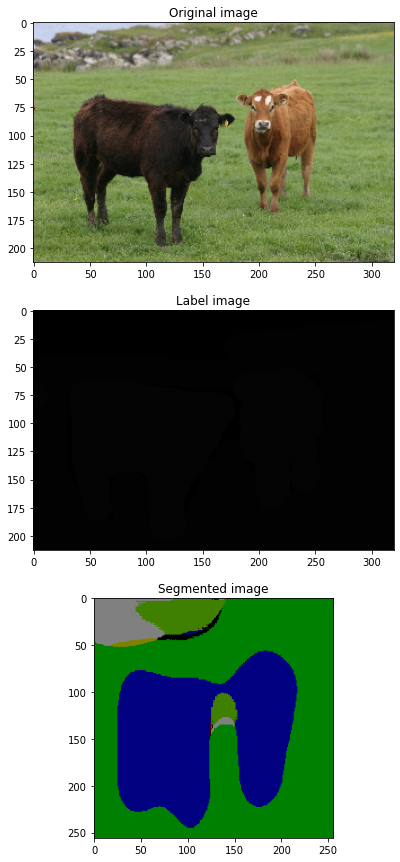

In [12]:
img = cv2.cvtColor(cv2.imread('MSRC/test/images/1_19_s.png'), cv2.COLOR_BGR2RGB)
label = cv2.imread('MSRC/test/labels/1_19_s_L.png')
pred = predict_image(model2, 'MSRC/test/images/1_19_s.png', 'MSRC', num_classes=14)

fig = plt.figure(figsize=(15,15))
fig.subplots(3,1)

plt.subplot(311)
plt.title('Original image')
plt.imshow(img)

plt.subplot(312)
plt.title('Label image')
plt.imshow(label, cmap='gray')

plt.subplot(313)
plt.title('Segmented image')
plt.imshow(pred)

plt.show()